## AIS Analyze Vessel Clusters

In [1]:
# from IPython.display import Image, HTML
import os
import numpy as np
import math
import pandas as pd
import datetime
from glob import glob
import geopy.distance
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings("ignore")           # Suppress Warning

### Global Variables

In [2]:
WorkingFolder = "/Users/cv0361/Desktop/TechChallenge/Data/csv/ConsolidatedAIS/"
OutputDir = WorkingFolder
MAX_CLUSTER = 5

### Common Functions

In [3]:
def Calc_Centroid_Radius(center_latlon, lat_max, lat_min, lon_max, lon_min):
    dist = list()
    
    # Center distance to the outer most coordinates
    dist.append(geopy.distance.distance((center_latlon[0], center_latlon[1]), (lat_max, lon_max)).mi)
    dist.append(geopy.distance.distance((center_latlon[0], center_latlon[1]), (lat_max, lon_min)).mi)
    dist.append(geopy.distance.distance((center_latlon[0], center_latlon[1]), (lat_min, lon_max)).mi)
    dist.append(geopy.distance.distance((center_latlon[0], center_latlon[1]), (lat_min, lon_min)).mi)
    
    print(dist)
    
    return round(max(dist), 2)

# Calc_Centroid_Radius(centers[0], stat.lat[1], stat.lat[2], stat.lon[1], stat.lon[2])

### Load Broadcast Data

In [4]:
Broadcast = pd.read_csv(WorkingFolder + "Broadcast_2014.csv", sep=",", parse_dates=['date_time'])
Broadcast.head()

,mmsi_id,date_time,lat,lon,speed_over_ground,course_over_ground,voyage_id,heading,status
0,366025993,2013-12-31 23:57:44,47.581332,-122.361145,0.0,39.599998,1,511,0
1,367160890,2013-12-31 23:57:44,45.835737,-123.990592,6.7,355.399990,2,359,15
2,366490600,2013-12-31 23:57:44,47.631067,-122.382117,0.0,192.100010,3,180,7
3,338000406,2013-12-31 23:57:44,48.123443,-123.444115,0.0,14.200000,4,511,0
4,367840001,2013-12-31 23:57:44,48.121267,-122.726412,11.4,55.400002,5,57,0


In [5]:
print("Raw Count:", Broadcast.shape[0])

Raw Count: 21517764


In [6]:
# Assign 0 to blank voyage id
Broadcast['voyage_id'] = Broadcast['voyage_id'].fillna(0)
Broadcast = Broadcast.astype({"voyage_id": int})           # cast type to int

### EDA and Stats

In [7]:
# Broadcast_Zone03_2017_01
# =========================
# 367094420      ARCTIC MARINER 	 type: 1001 - Fishing, 31x9.28       lots of points   multiple trips, same route
# 367565680      ADAMANT             type: 1001 - Fishing, 18x8          lots of points   ?
# 367373760      NORTH SEA           type: 1001 - Fishing, 37x10                          ?
# 440102000      TORAH               type: 1004 - Freight, 115.8x16.62   lots of points   weird
# 636014222      Zim Rotter          type: 1004 - Freight, 349x45.73                      Going some where
# 367322830      GYRFALCON           type: 1025 - Towing, 30.63x10.4     lots of points   weird behavior

# Broadcast_Zone10_2014_01
# =========================
# 316500126                          type: 31 - TugTow,     15x5        irregular pattern towing
# 367528210                          type: 31 - TugTow,     33x13       irregular pattern towing
# 316881510                          type: 52 - TugTow,     28x13       irregular pattern towing
# 366025993                          type: 52 - TugTow,     21x7        pattern?
# 538001471                          type: 70 - Cargo,     302x44      path pattern
# 538284070                          type: 70 - Cargo,     184x31      path pattern
# 229560200                          type: 70 - Cargo,     350x42      path pattern
# 235733603                          type: 80 - Tanker,    183x32      path pattern
# 538007477                          type: 0 - Tanker?,    170x27      Going some where
# 366089092                          type: 0, 30x6        Infrequent ping per trip


mmsi = 366985110 
voyage_id = 0

In [8]:
# Select a specific Vessel
df = Broadcast.loc[Broadcast.mmsi_id==mmsi, ['date_time', 'lat', 'lon', 'speed_over_ground', 'voyage_id']]  # & (Broadcast.voyage_id.isnull()
df.rename(columns={'lat':'latitude', 'lon':'longitude'}, inplace=True)

# Extract Date and Hour
df['PingDate'] = df['date_time'].dt.date
df['PingHour'] = df['date_time'].dt.hour

print("Rows:", df.shape)
df.head()

Rows: (33766, 7)


,date_time,latitude,longitude,speed_over_ground,voyage_id,PingDate,PingHour
64,2013-12-31 23:57:44,46.204338,-123.950212,0.0,66,2013-12-31,23
823,2014-01-01 00:00:44,46.204383,-123.950225,0.0,66,2014-01-01,0
1439,2014-01-01 00:01:54,46.204358,-123.950217,0.0,66,2014-01-01,0
1946,2014-01-01 00:02:53,46.204418,-123.950237,0.0,66,2014-01-01,0
2667,2014-01-01 00:04:24,46.204395,-123.950195,0.0,66,2014-01-01,0


In [9]:
# # Fudge some anomaly
# df.loc[df.date_time=='2017-01-10 01:12:31', 'latitude'] = 70.25
# df.loc[df.date_time=='2014-01-01 00:03:06', 'longitude'] = -100.123
# df.head()

In [10]:
# Get Unique voyage Id
df.voyage_id.unique()

array([66])

In [11]:
# # Select 1 voyage
# df = df.loc[df.voyage_id==1]
# df.shape

In [12]:
# Calculate Statistics
# df.describe()
df.agg(['count', 'max', 'min', 'mean', 'median', 'std', 'nunique'])   

,date_time,latitude,longitude,speed_over_ground,voyage_id,PingDate,PingHour
count,33766,33766.000000,33766.000000,33766.000000,33766.0,33766,33766.000000
max,2014-01-31 23:59:20,46.211372,-123.924967,25.700001,66.0,2014-01-31,23.000000
min,2013-12-31 23:57:44,46.197055,-123.950918,0.000000,66.0,2013-12-31,0.000000
mean,2014-01-15 03:12:57.018539264,46.204399,-123.950213,0.023023,66.0,NaN,11.525854
nunique,33766,212.000000,192.000000,28.000000,1.0,30,24.000000
median,NaN,46.204398,-123.950217,0.000000,66.0,NaN,12.000000
std,NaN,0.000098,0.000263,0.318203,0.0,NaN,6.961592


### Sampling Data Hourly

In [13]:
mygroup = df.groupby(['voyage_id', 'PingDate', 'PingHour'])
sampling = mygroup['latitude', 'longitude', 'speed_over_ground'].mean()  
sampling['PingCount'] = mygroup['latitude'].count()
sampling.reset_index(inplace=True)

print("Rows:", sampling.shape[0])
sampling.head()

Rows: 642


,voyage_id,PingDate,PingHour,latitude,longitude,speed_over_ground,PingCount
0,66,2013-12-31,23,46.204338,-123.950212,0.000000,1
1,66,2014-01-01,0,46.204382,-123.950204,0.025490,51
2,66,2014-01-01,1,46.204384,-123.950236,0.002083,48
3,66,2014-01-01,2,46.204389,-123.950230,0.003922,51
4,66,2014-01-01,3,46.204414,-123.950230,0.000000,52


In [14]:
# Formulate Popup text for the Map
sampling['Text'] = sampling.apply(lambda x: "{}:{}-V:{} - SOG: {} - Count: {} ({}, {})".format(x.PingDate, x.PingHour, x.voyage_id, round(x.speed_over_ground, 1), x.PingCount, round(x.latitude, 3), round(x.longitude, 3)), axis=1)   
sampling.head()

,voyage_id,PingDate,PingHour,latitude,longitude,speed_over_ground,PingCount,Text
0,66,2013-12-31,23,46.204338,-123.950212,0.000000,1,2013-12-31:23-V:66 - SOG: 0.0 - Count: 1 (46.2...
1,66,2014-01-01,0,46.204382,-123.950204,0.025490,51,2014-01-01:0-V:66 - SOG: 0.0 - Count: 51 (46.2...
2,66,2014-01-01,1,46.204384,-123.950236,0.002083,48,2014-01-01:1-V:66 - SOG: 0.0 - Count: 48 (46.2...
3,66,2014-01-01,2,46.204389,-123.950230,0.003922,51,2014-01-01:2-V:66 - SOG: 0.0 - Count: 51 (46.2...
4,66,2014-01-01,3,46.204414,-123.950230,0.000000,52,2014-01-01:3-V:66 - SOG: 0.0 - Count: 52 (46.2...


In [15]:
# Output Sampling Data
# sampling.to_csv(OutputDir + 'sampling_366089092.csv', index=None, header = True)

### Clustering via K-means
* https://github.com/JosephMagiya/Clustering-GPS-Co-ordinates--Forming-Regions./blob/master/Clustering-GPS-Co-ordinates--Forming-Regions.ipynb

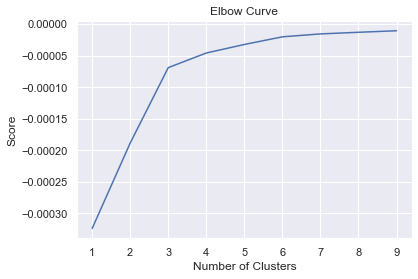

In [16]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['latitude']]
X_axis = df[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Plot labels
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [17]:
# Cluster all the coordinances
X = df[['latitude', 'longitude']]

kmeans = KMeans(n_clusters=MAX_CLUSTER, init='k-means++')

kmeans.fit(X)                                   # Compute k-means clustering. # Compute k-means clustering.
df['cluster_label'] = kmeans.predict(X)         # Labels of each point
centers = kmeans.cluster_centers_               # Coordinates of cluster centers.

df.head(3)

,date_time,latitude,longitude,speed_over_ground,voyage_id,PingDate,PingHour,cluster_label
64,2013-12-31 23:57:44,46.204338,-123.950212,0.0,66,2013-12-31,23,0
823,2014-01-01 00:00:44,46.204383,-123.950225,0.0,66,2014-01-01,0,0
1439,2014-01-01 00:01:54,46.204358,-123.950217,0.0,66,2014-01-01,0,0


In [18]:
centers

array([[  46.20439842, -123.95021678],
       [  46.202277  , -123.937133  ],
       [  46.20606483, -123.9440315 ],
       [  46.19808933, -123.92775533],
       [  46.21088767, -123.95006867]])

In [19]:
# Distribution Summary for all clusters - Cluster, ping counts
PingCluster = df.groupby('cluster_label')['date_time'].count().reset_index()
PingCluster.rename(columns={'date_time':'PingCount'}, inplace=True)
PingCluster.sort_values('PingCount')

,cluster_label,PingCount
1,1,3
3,3,3
4,4,3
2,2,6
0,0,33751


In [20]:
# Locate and agg data for a selected cluster
Select_Cluster = 0

stat = df.loc[df.cluster_label==Select_Cluster].agg(['count', 'max', 'min'])   
stat

,date_time,latitude,longitude,speed_over_ground,voyage_id,PingDate,PingHour,cluster_label
count,33751,33751.000000,33751.000000,33751.0,33751,33751,33751,33751
max,2014-01-31 23:59:20,46.206548,-123.948275,9.3,66,2014-01-31,23,0
min,2013-12-31 23:57:44,46.204057,-123.950482,0.0,66,2013-12-31,0,0


In [21]:
# Get Cluster Radius
Calc_Centroid_Radius(centers[Select_Cluster], stat.latitude[1], stat.latitude[2], stat.longitude[1], stat.longitude[2])

[0.1752539194492259, 0.14901261792610832, 0.09605943213489654, 0.02679279582095836]


0.18

### Plot Vessel Coordinates, Clusters, and Hourly Sampling coordinates

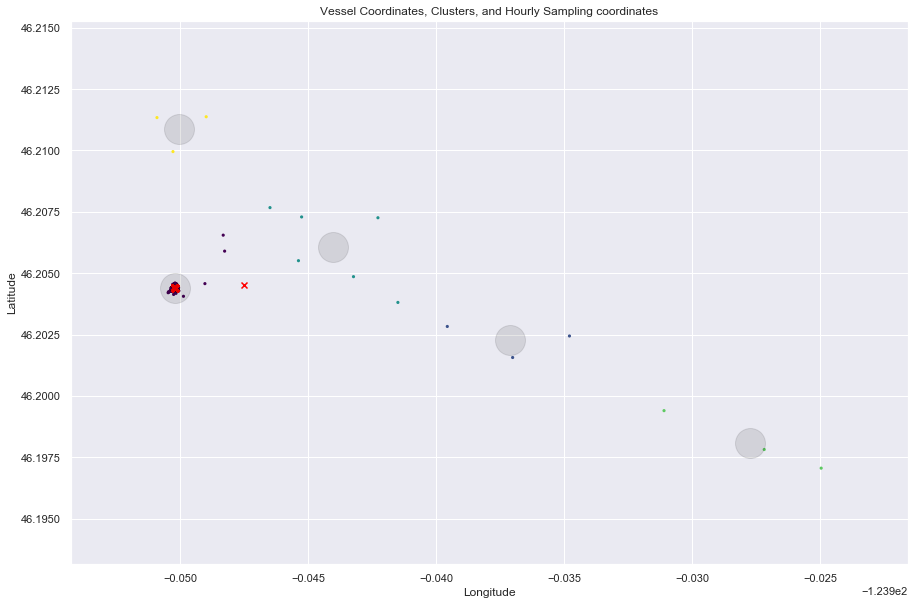

In [27]:
# various scatter plots
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()

# All coordinates
ax.scatter(df.longitude, df.latitude, s=10, lw=0, c=df['cluster_label'], cmap='viridis', alpha=1)
# Hourly Sampling coordinates
ax.scatter(sampling.longitude, sampling.latitude, marker='x', color='red')
# Clusters centroids
ax.scatter(centers[:, 1], centers[:, 0], c='black', s=900, alpha=0.1)

# Plot Labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Vessel Coordinates, Clusters, and Hourly Sampling coordinates')
plt.show()

### Real Map of Ping Coordinates and Popups
* https://github.com/python-visualization/folium
* https://github.com/collinreinking/longitude_latitude_dot_plots_in_python_with_folium/blob/master/MapsTutorials.ipynb
* https://georgetsilva.github.io/posts/mapping-points-with-folium/

In [23]:
# Plot just the Hourly Sampling Pings Coordinates
X = sampling

MapCoordinates = X[['latitude', 'longitude']].values
PopupText = X.Text.values 

mapit = folium.Map(location=MapCoordinates[0], zoom_start=8)

for index in range(0, len(MapCoordinates)):
    folium.Marker(MapCoordinates[index], popup=PopupText[index]).add_to(mapit)  #, popup=PopupText[index]
    
# mapit.save( 'map.html')
mapit

In [26]:
# # ********* Plot all coordinates; Very slow might need filtering to reduce points
# X = df  #.head()

# MapCoordinates = X[['latitude', 'longitude']].values
# mapit = folium.Map(location=MapCoordinates[0], zoom_start=8)

# for index in range(0, len(MapCoordinates)):
#     folium.Marker(MapCoordinates[index]).add_to(mapit)  #, popup=PopupText[index]
    
# # mapit.save( 'map.html')
# mapit